In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from utils import *

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Import Support Vector Classifier (SVM)
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate



# 1. Visualize and preprocess the data
## A) Load data and understand composition

In [2]:
# Load data
subject = load_subject()
n_subjects = 27
subjects_list = []
for subject_number in range(1, n_subjects+1):
    subjects_list.append(load_subject(subject_number))
subjects_list[0]

{'number': 1,
 'emg_rectified': array([[0.0684, 0.0024, 0.0024, ..., 0.0488, 0.0024, 0.0342],
        [0.0586, 0.0024, 0.0024, ..., 0.0415, 0.0024, 0.0293],
        [0.0562, 0.0024, 0.0024, ..., 0.0391, 0.0024, 0.0244],
        ...,
        [0.0024, 0.0024, 0.0024, ..., 0.0342, 0.0024, 0.0073],
        [0.0024, 0.0024, 0.0024, ..., 0.0366, 0.0024, 0.0073],
        [0.0024, 0.0024, 0.0024, ..., 0.0391, 0.0024, 0.0024]]),
 'stimulus': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8),
 'repetition': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8)}

## B) Exploration of the data
There are measures at 100686 time points from 10 channels (probably 10 electrodes). See below that there are 12 types of movement performed and they are repeated 10 times. The number of samples for each trial is different because of the nature of each exercise.
The data is partially preprocessed

In [3]:
subjects_list[0].keys()

dict_keys(['number', 'emg_rectified', 'stimulus', 'repetition'])

In [4]:
from utils import get_attributes, explore_data

n_stimuli,n_channels, n_repetitions = explore_data(subjects_list[0])
emg, stimulus, repetition= get_attributes(subjects_list[0])


How many types of movement are there? 12
How many repetitions are there? 10
There are 10 channels.
Length of trials: 


Channel                                                               
             1      2      3      4      5      6      7      8      9      10
Stimuli                                                                       
1         305.0  354.0  346.0  371.0  438.0  372.0  430.0  412.0  435.0  352.0
2         193.0  388.0  233.0  234.0  244.0  252.0  316.0  227.0  229.0  302.0
3         524.0  390.0  481.0  433.0  460.0  515.0  199.0  360.0  424.0  356.0
4         348.0  296.0  287.0  276.0  281.0  242.0  278.0  315.0  330.0  329.0
5         452.0  453.0  382.0  416.0  376.0  418.0  430.0  339.0  318.0  368.0
6         293.0  305.0  432.0  286.0  301.0  306.0  254.0  299.0  253.0  329.0
7         246.0  240.0  266.0  263.0  252.0  187.0  259.0  325.0  299.0  278.0
8         211.0  294.0  277.0  359.0  333.0  372.0  374.0  287.0  306.0  185.0
9         197.0  250.0  234.0  222.0  295.0  281.0  269.0  330.0  289.0  241.0
10        458.0  184.0  184.0  270.0  407.0  188.0  338.0  379.0  473.0  306.0
11        186.0  285.0  305.0  195.0  230.0  240.0  222.0  318.0  238.0  272.0
12        341.0  429.0  189.0  239.0  526.0  261.0  185.0  521.0  224.0  319.0

**Observations:**
All the trials did not last the same time, and can not be put together in a tensor:

## C) Visualize and preprocess

### Window and envelope
Now, let's smooth and visualize the data accross the channels. In this example, we will illustrate using data from a single trial (repetition 1 of stimulus 1) using moving average for detecting the envelope.
If plot emg_windows[0][0]: will see 1rst trial and 1rst repetition

In [5]:
from utils import smooth_data

for subject in subjects_list:
    subject = smooth_data(subject, n_stimuli, n_repetitions)

subjects_list[0].keys()

dict_keys(['number', 'emg_rectified', 'stimulus', 'repetition', 'emg_windows', 'emg_envelopes'])

## Visualize the data

Text(0.5, 0.98, 'Envelopes of the EMG signal')

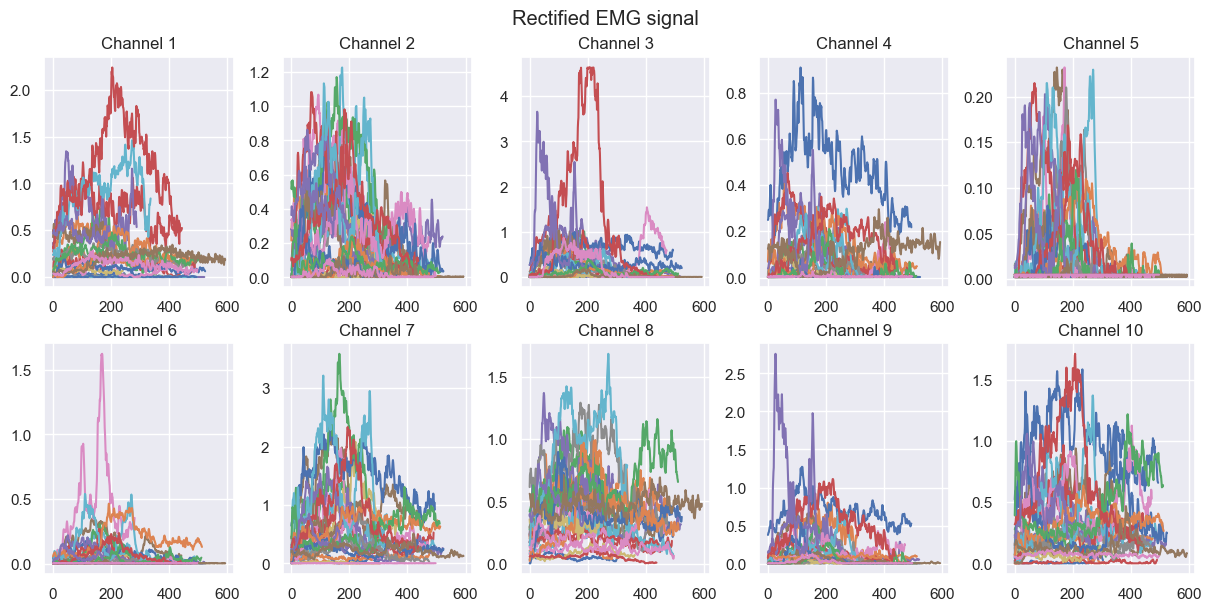

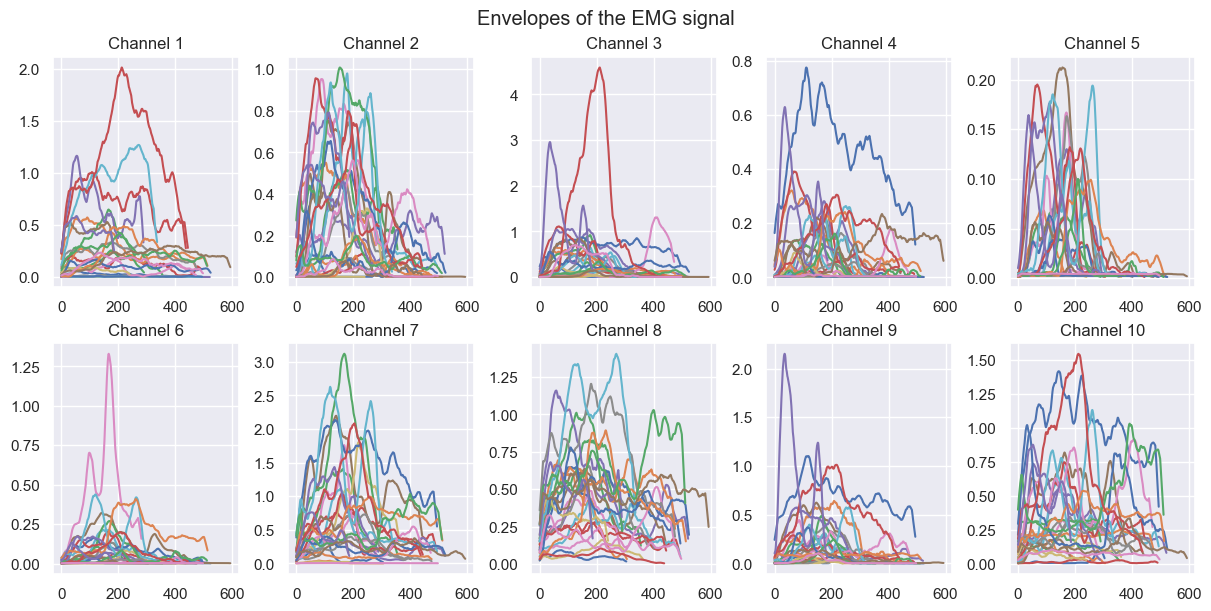

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

# Plot Rectified EMG signal
for channel_idx in range(n_channels): 
    for subject in subjects_list:
        emg_windows = subject['emg_windows']
        ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# Plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for channel_idx in range(n_channels): 
    for subject in subjects_list:    
        emg_envelopes = subject['emg_envelopes']
        ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")
#plt.legend([subject['number'] for subject in subjects_list])

Text(0.5, 0.98, 'Envelopes of the EMG signal')

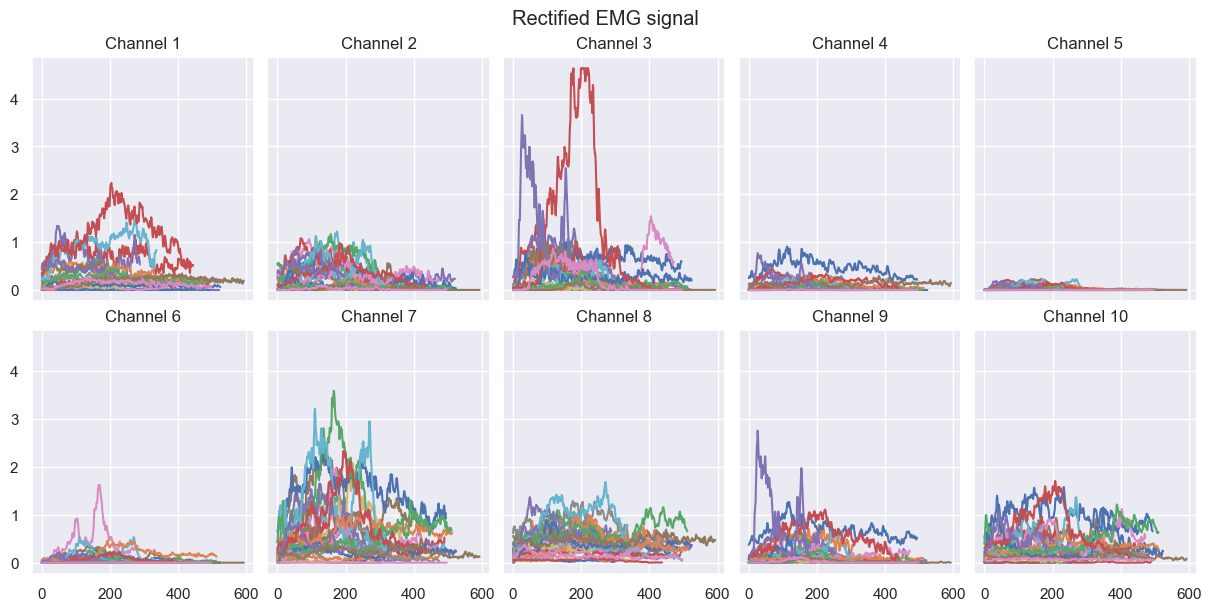

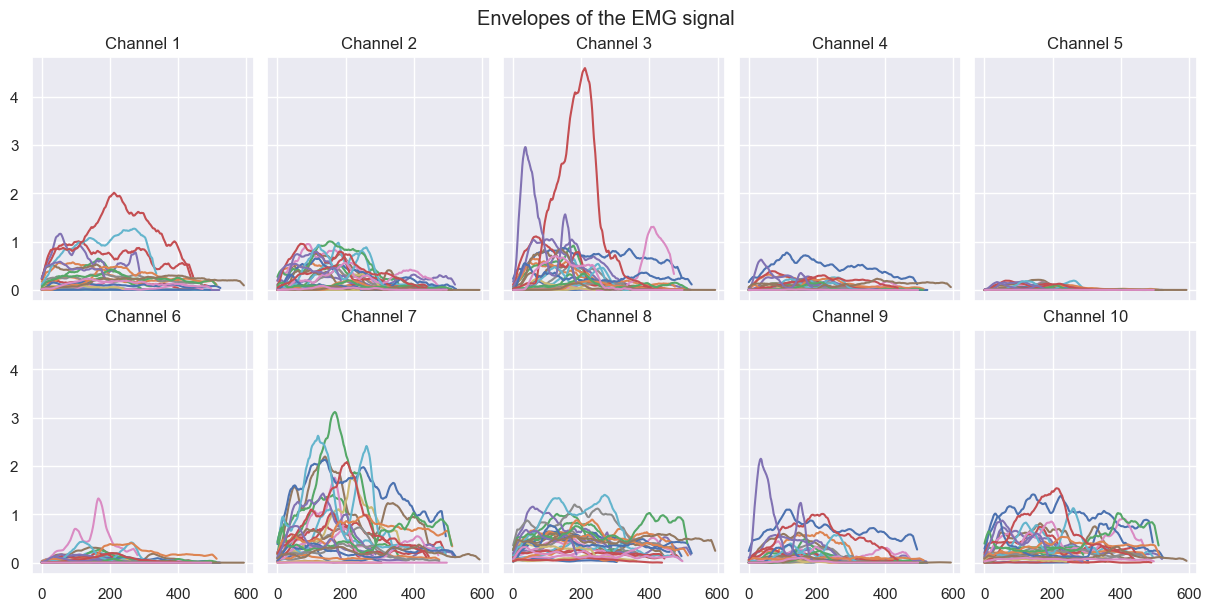

In [7]:
# Now we plot all the channels on the same y-scale for a better comparison
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()


# Plot rectified EMG signal
for channel_idx in range(n_channels): 
    for subject in subjects_list:
        emg_windows = subject['emg_windows']
        ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# Plot envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(n_channels): 
    for subject in subjects_list:
        emg_envelopes = subject['emg_envelopes']
        ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")


### Visualizing across repetitions

Remember that we were only looking at a single trial in the previous section. 

To check for the robustness of the signal, we will generally need to repeat the stimulus multiple times and look at the trend of the signal quality over time.

In [8]:
for subject in subjects_list:
    emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            #mean across time for each channel
            emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 
    subject['emg_average_activations'] = emg_average_activations

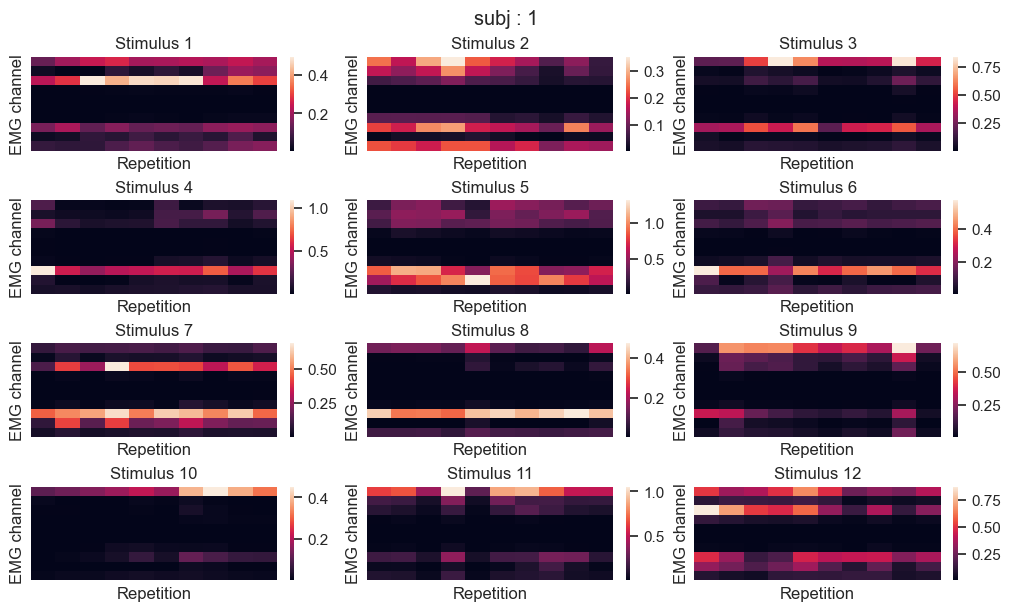

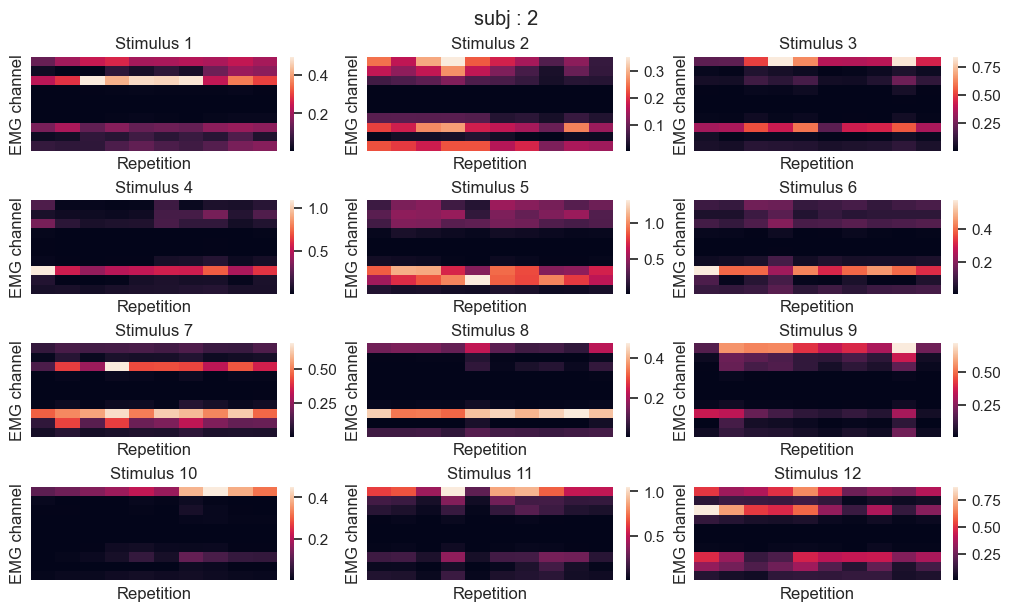

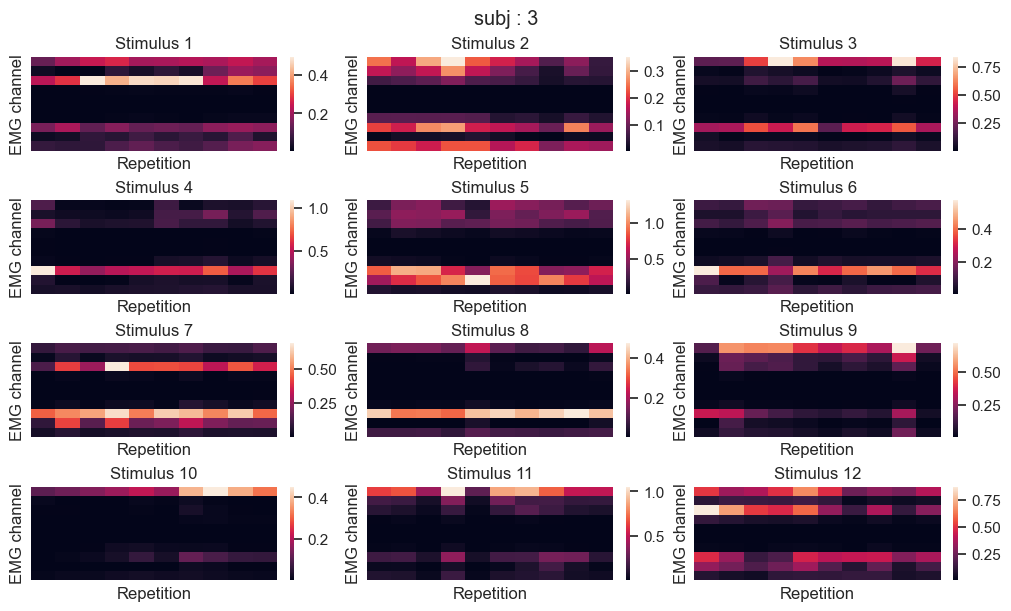

In [9]:
# Visualisation for 3 subject
for subject in subjects_list[:3]:
    fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
    fig.suptitle(f'subj : {subject['number']}')
    ax = ax.ravel()
    
    emg_average_activations = subject['emg_average_activations']
    for stimuli_idx in range(n_stimuli):
        sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
        ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
        ax[stimuli_idx].set_xlabel("Repetition")
        ax[stimuli_idx].set_ylabel("EMG channel")

# 2. Extract features for classification

In [10]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)

# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)

# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# # Slope sign changes (SSC)
# It counts the number of times the slope changes direction.
ssc = lambda x: np.sum(
    (np.diff(np.sign(np.diff(x, axis=0)), axis=0) != 0).astype(int),
    axis=0
)


## Build the dataset

In [11]:
n_features_per_channel=6
# Initialize lists to store datasets and labels for all subjects
all_datasets = []
all_labels = []
all_filtered_datasets = []
all_filtered_labels = []
all_filtered_datasets_highpassed = []
all_filtered_labels_highpassed = []

# Iterate over each subject, process their data, and collect datasets and labels
for subject in subjects_list:
    # Load data for the current subject
    emg, stimulus, repetition = get_attributes(subject)
    
    # Build dataset and labels for the current subject
    dataset, labels = build_dataset_from_ninapro(
        emg=emg,
        stimulus=stimulus,
        repetition=repetition,
        features=[mav, std, maxav, rms, wl, ssc]  
    )
    # Append the basic dataset to the global lists
    all_datasets.append(dataset)
    all_labels.append(labels)

    #REMOVE FLATLINE CHANNELS
    filtered_dataset, adjusted_labels, retained_channels = filter_channels_with_zero_std(dataset, labels, n_features_per_channel)
    all_filtered_datasets.append(filtered_dataset)
    all_filtered_labels.append(adjusted_labels)

    #HIGH PASS
    emg_highpassed = np.zeros_like(emg)  # Same shape as original dataset
    # Filter the entire dataset along time axis for each channel
    for channel_idx in range(emg.shape[1]):
        emg_highpassed[:, channel_idx] = high_pass_filter(emg[:, channel_idx], cutoff=20, fs=1000)
    #build dataset for highpassed emg
    dataset_highpassed, labels_highpassed =build_dataset_from_ninapro(
        emg=emg_highpassed,
        stimulus=stimulus,
        repetition=repetition,
        features=[mav ,std, maxav, rms, wl, ssc]  # Using MAV as the feature
    )
    filtered_dataset_highpassed, adjusted_labels_highpassed, retained_channels_highpassed = filter_channels_with_zero_std(dataset_highpassed, labels_highpassed, n_features_per_channel)
    all_filtered_datasets_highpassed.append(filtered_dataset_highpassed)
    all_filtered_labels_highpassed.append(adjusted_labels_highpassed)

# Combine datasets and labels across all subjects
combined_dataset = np.vstack(all_datasets)  # Stack datasets vertically
combined_labels = np.hstack(all_labels)     # Stack labels horizontally
combined_filtered_datasets=np.vstack(all_filtered_datasets)
combined_filtered_labels=np.hstack(all_filtered_labels)
combined_filtered_datasets_highpassed=np.vstack(all_filtered_datasets_highpassed)
combined_filtered_labels_highpassed=np.hstack(all_filtered_labels_highpassed)

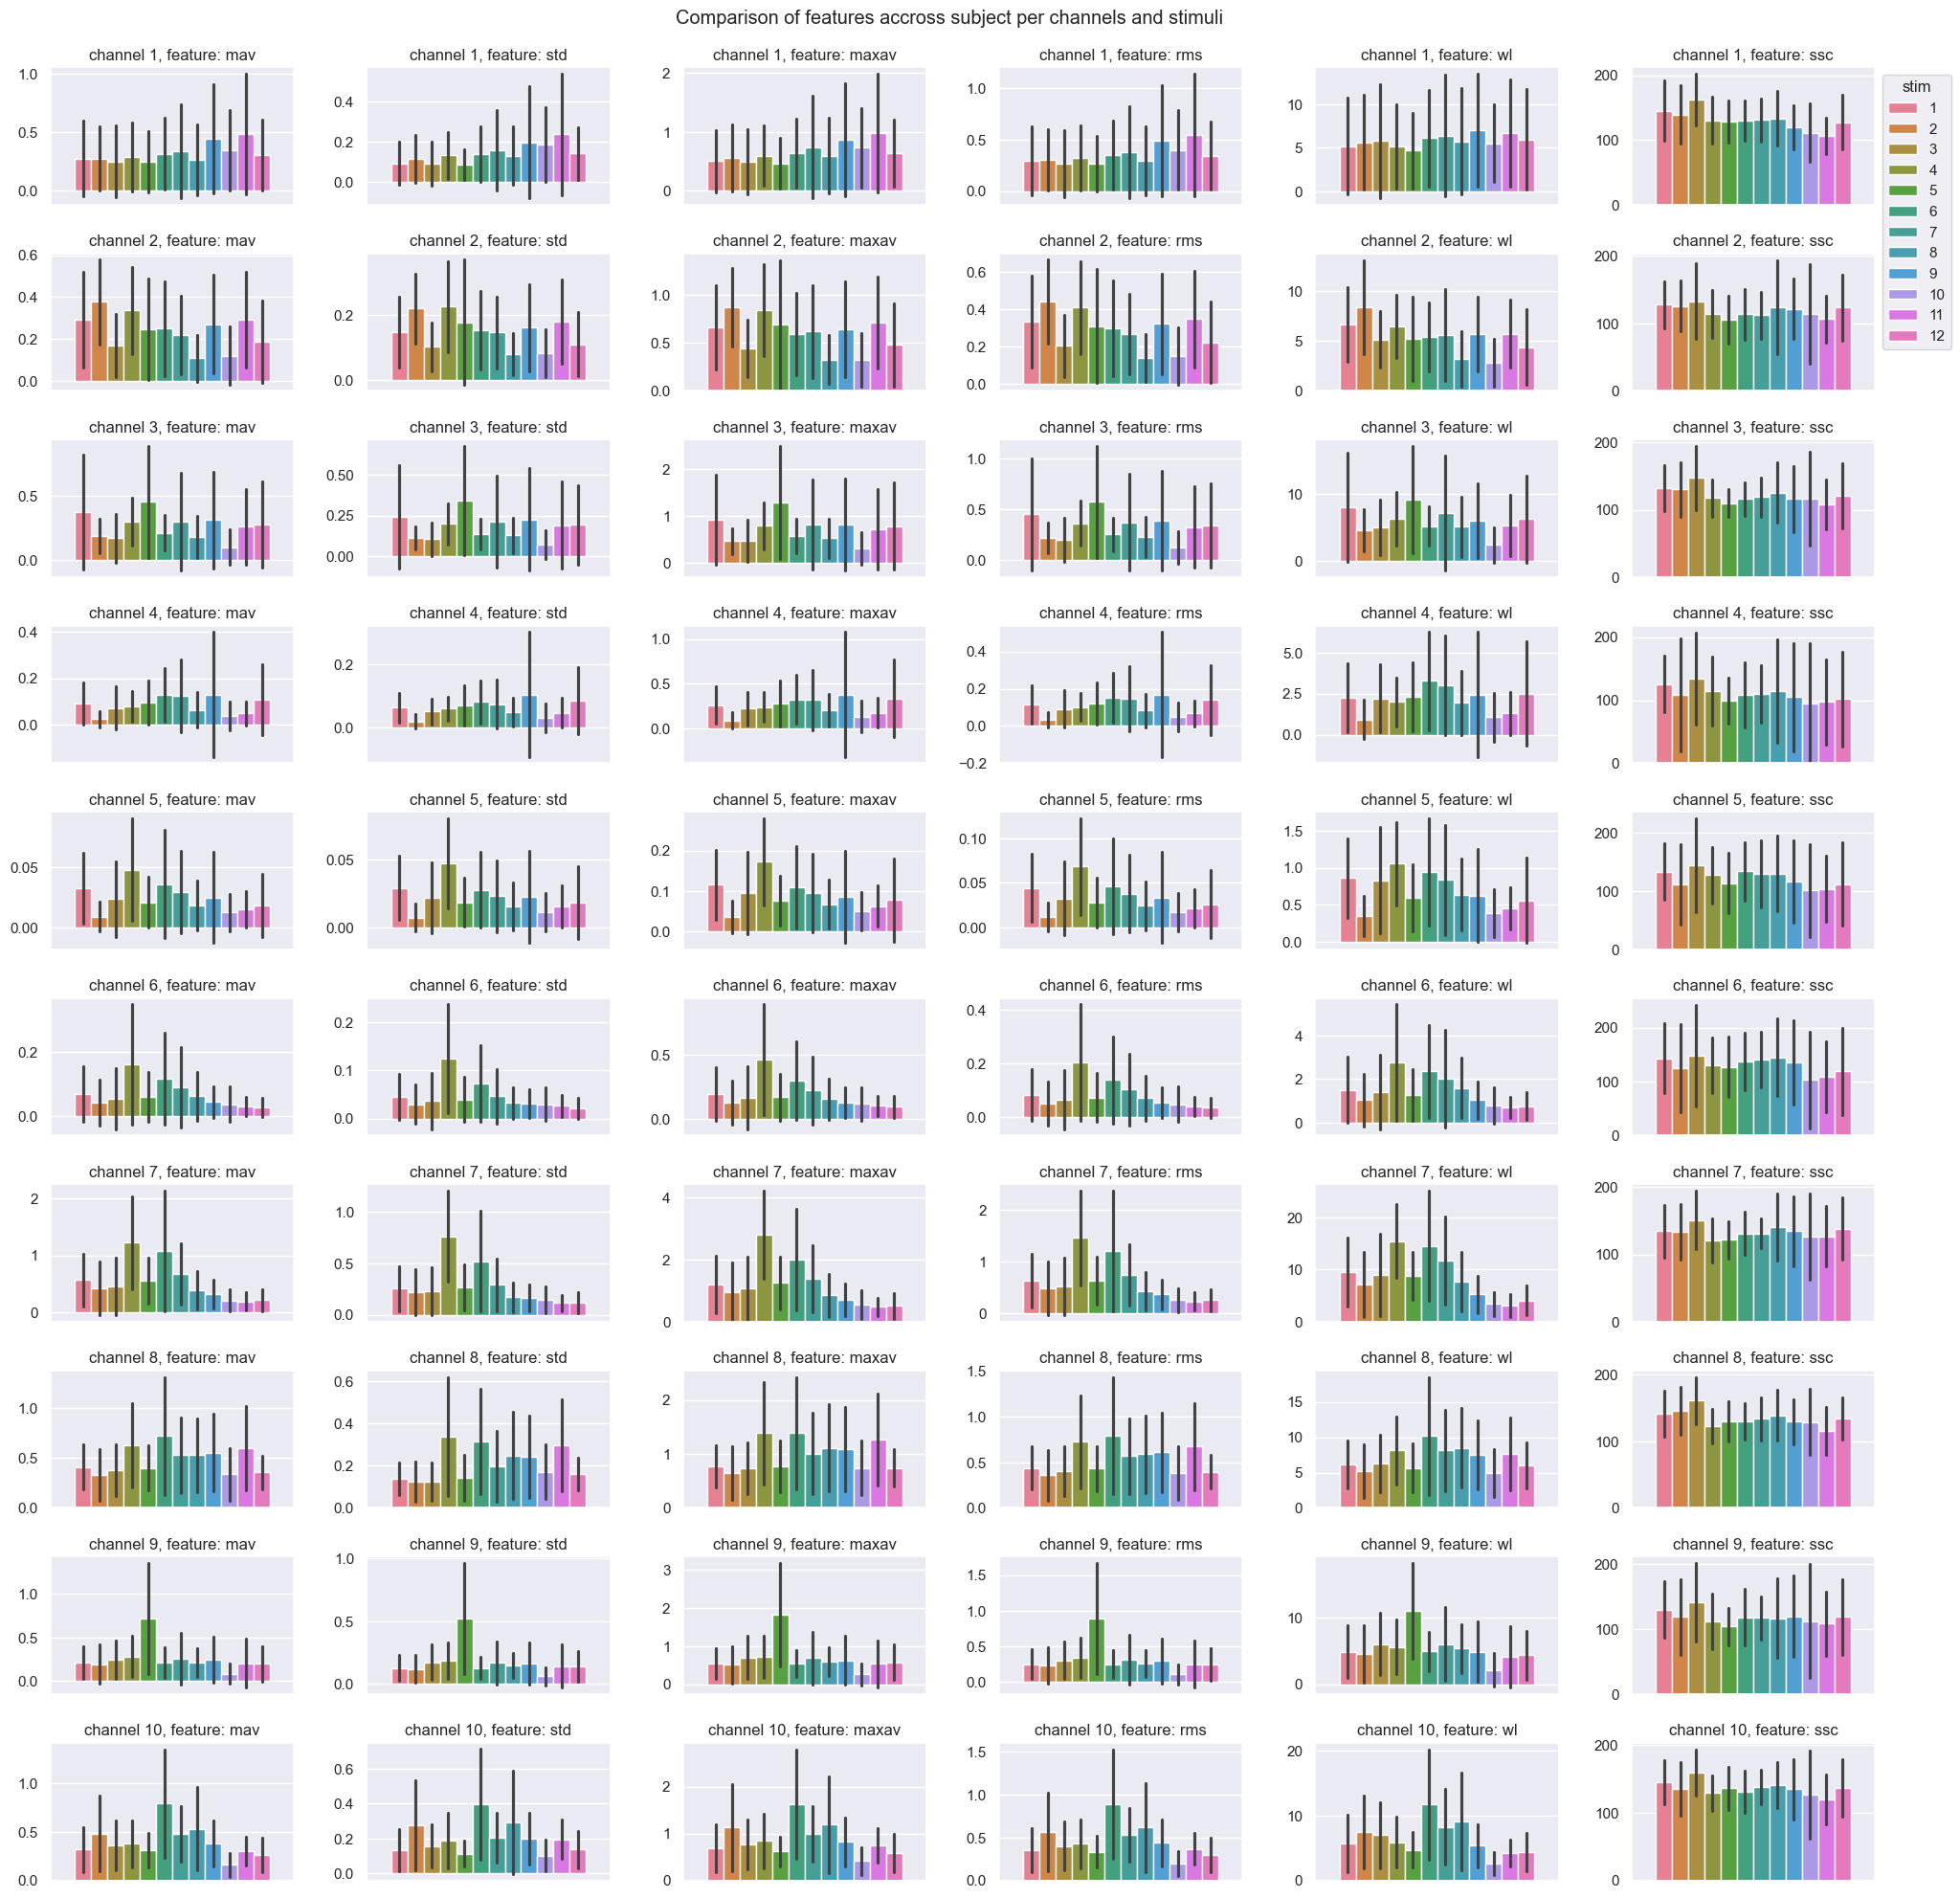

In [13]:
# vizualize and compare features
fig, axs = plt.subplots(10, 6, figsize=(20, 20))
fig.suptitle('Comparison of features accross subject per channels and stimuli',  y= 1)
fig.tight_layout()

for j, feature in enumerate(['mav','std', 'maxav', 'rms', 'wl', 'ssc'] ): 
    for i in range(10) : 
        df = features_to_df(feature, all_datasets, n_stimuli,n_repetitions, n_channels = 10)
        axs[i][j].set_title(f'channel {i + 1}, feature: {feature}')

        sns.barplot(df, y =i, hue='stim', ax= axs[i][j],errorbar='sd')
        
        axs[i][j].get_legend().set_visible(False)
        axs[i][j].set_ylabel('')

        if i == 0 and j == 5 :
            axs[i][j].get_legend().set_visible(True)
            sns.move_legend(axs[i][j], "upper left", bbox_to_anchor=(1, 1))
        

# 3. Classifier SVM

## 3.1 each subject as a test

#### SPLIT + NOT SUFFLE

In [42]:
# Scalar for normalization
scaler = StandardScaler()

# Normal dataset --> This is better 
#X_scaled = scaler.fit_transform(combined_filtered_datasets) 
#best_param = {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}  
#labels = combined_filtered_labels

# High passed dataset --> This one do worst
X_scaled = scaler.fit_transform(combined_filtered_datasets_highpassed) 
labels = combined_filtered_labels_highpassed
best_param =  {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}

# Initialize the SVM classifier
clf = SVC(**best_param)  

# Perform cross-validation
# By default, the cross_val_score function in scikit-learn does not shuffle samples
# Thus by taking subject_number fold each fold test set is composed exactly by the trials of 1 subject 
results = cross_validate(clf, X_scaled, labels, cv=subject_number, return_train_score = True)

Testing accuracy scores of all models: [0.375      0.14166667 0.45       0.26666667 0.30833333 0.225
 0.175      0.41666667 0.20833333 0.36666667 0.29166667 0.275
 0.30833333 0.35       0.36666667 0.29166667 0.4        0.25833333
 0.25833333 0.26666667 0.25       0.3        0.38333333 0.28333333
 0.38333333 0.38333333 0.09166667]
Mean testing accuracy across all models: 0.2990740740740741


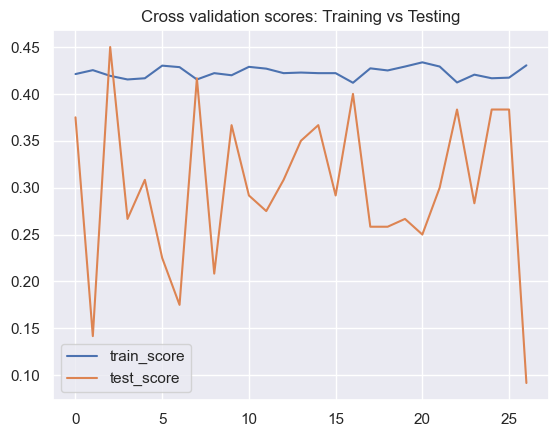

In [43]:
plt.plot( results['train_score'], label = 'train_score')
plt.plot(results['test_score'], label = 'test_score')
plt.legend()
plt.title("Cross validation scores: Training vs Testing")

# Print the accuracy scores for each fold
print(f"Testing accuracy scores of all models: {results['test_score']}")

# Print the mean accuracy across all folds
print(f"Mean testing accuracy across all models: {np.mean(results['test_score'])}")


#### SPLIT + SHUFFLE

In [29]:
# Take each subject as a test - Do the same as above but with the option of the dataset shuffle after the split
accuracy_test = []
accuracy_train = []
scaler = StandardScaler()

for subj_id in range(len(subjects_list)):

    # Split
    X_train, X_test, y_train, y_test  = split(all_filtered_datasets, all_filtered_labels, subj_test_ids=[subj_id], shuffle = True)
    best_param = {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}  

    #X_train, X_test, y_train, y_test  = split(all_filtered_datasets_highpassed, all_filtered_labels_highpassed, subj_test_ids=[subj_id], shuffle = True)
    #best_param =  {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}

    # Normalizing 
    X_train_z = scaler.fit_transform(X_train) 
    X_test_z = scaler.transform(X_test)       

    # We are using Support Vector Machine (SVM) 
    clf = SVC(**best_param)  # linear seems to work best
    clf.fit(X_train_z, y_train)  

    # Accuracy 
    accuracy_train.append(accuracy_score(y_train, clf.predict(X_train_z) ))
    accuracy_test.append(accuracy_score(y_test, clf.predict(X_test_z)))

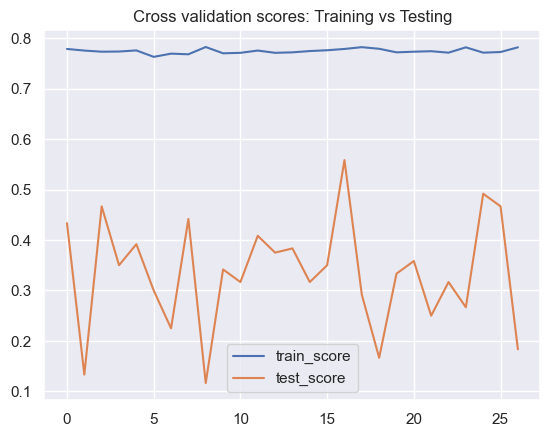

Mean accruacy over the training: 0.33


In [30]:
plt.plot(accuracy_train, label = 'train_score')
plt.plot(accuracy_test, label = 'test_score')
plt.legend()
plt.title("Cross validation scores: Training vs Testing")
plt.show()

print(f'Mean accruacy over the training: {np.round(np.mean(accuracy_test), 2)}')

#### Feature selection and dimension reduction

We tried to improve our model by using PCA on the dataset splitted with the method that allow shuffling

Text(0, 0.5, 'cumulative explained variance')

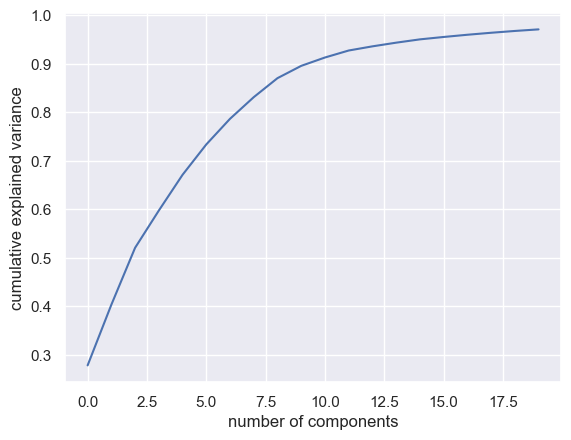

In [38]:
# Feature selection and dimension reduction with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
X_train, X_test, y_train, y_test  = split(all_filtered_datasets, all_filtered_labels, subj_test_ids=[subj_id], shuffle = True)
#X_train, X_test, y_train, y_test  = split(all_filtered_datasets_highpassed, all_filtered_labels_highpassed, subj_test_ids=[subj_id], shuffle = True)

X_train_z = scaler.fit_transform(X_train) 

pca.fit(X_train_z)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [34]:
from sklearn.decomposition import PCA
n_chosen_components = 15
pca = PCA(n_components=n_chosen_components)

accuracy_test = []
accuracy_train = []
scaler = StandardScaler()

for subj_id in range(len(subjects_list)):

    # Split
    X_train, X_test, y_train, y_test  = split(all_filtered_datasets, all_filtered_labels, subj_test_ids=[subj_id], shuffle = True)
    best_param = {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}  

    #X_train, X_test, y_train, y_test  = split(all_filtered_datasets_highpassed, all_filtered_labels_highpassed, subj_test_ids=[subj_id], shuffle = True)
    #best_param =  {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
    
    # Normalizing 
    X_train_z = scaler.fit_transform(X_train) 
    X_test_z = scaler.transform(X_test)       

    # Dim reduction
    pca.fit(X_train_z)
    X_train_pca = pca.transform(X_train_z)
    X_test_pca = pca.transform(X_test_z)

    # We are using Support Vector Machine (SVM) 
    clf = SVC(**best_param)  
    clf.fit(X_train_pca, y_train)

    # Accuracy 
    accuracy_train.append(accuracy_score(y_train, clf.predict(X_train_pca) ))
    accuracy_test.append(accuracy_score(y_test, clf.predict(X_test_pca)))

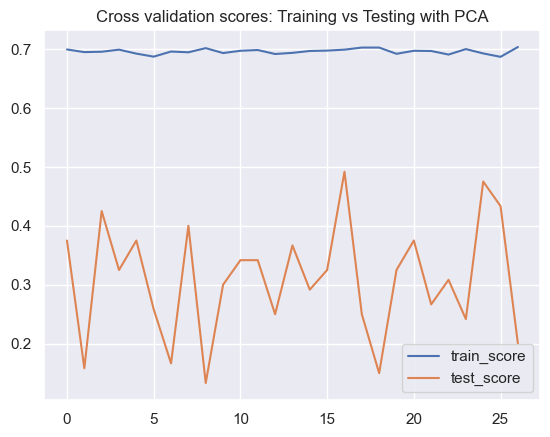

Mean accruacy over the training: 0.31


In [35]:
plt.plot(accuracy_train, label = 'train_score')
plt.plot(accuracy_test, label = 'test_score')
plt.legend()
plt.title("Cross validation scores: Training vs Testing with PCA")
plt.show()

print(f'Mean accruacy over the training: {np.round(np.mean(accuracy_test), 2)}')

It will not improve the accuracy so we will keep the data without PCA

# 5. Cross validation by varying the number of subject in test vs train

In [32]:
ACCU = []
SIZE =[]
subj = []
for i in range(n_subjects - 1) : 
    subj.append(i + 1)

    #### Option with the sklearn function : not shuffle inside the train and test ####
    X_train, X_test, y_train, y_test = train_test_split(combined_filtered_datasets, combined_filtered_labels, test_size=(i+1)/n_subjects, shuffle=False)
    best_param = {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
    
    #X_train, X_test, y_train, y_test = train_test_split(combined_filtered_datasets_highpassed, combined_filtered_labels_highpassed, test_size=(i+1)/n_subjects, shuffle=False)
    #best_param = {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}


    #### Option suffle inside the train and test  ####
    #X_train, X_test, y_train, y_test  = split(all_filtered_datasets, all_filtered_labels, subj_test_ids=[subj_id], shuffle = True)
    #best_param = {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}  

    #X_train, X_test, y_train, y_test  = split(all_filtered_datasets_highpassed, all_filtered_labels_highpassed, subj_test_ids=[subj_id], shuffle = True)
    #best_param =  {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}


    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)  
    X_test_z = scaler.transform(X_test)        

    clf = SVC(**best_param)  
    clf.fit(X_train_z, y_train)  

    y_pred = clf.predict(X_test_z)

    accuracy = accuracy_score(y_test, y_pred)
    ACCU.append(accuracy)
    SIZE.append(len(subj))
    print(f"Accuracy score for split test_size = {i+1} subject, {np.round((i+1)/n_subjects, 2)} % of the dataset : {accuracy}")

Accuracy score for split test_size = 1 subject, 0.04 % of the dataset : 0.18333333333333332
Accuracy score for split test_size = 2 subject, 0.07 % of the dataset : 0.2833333333333333
Accuracy score for split test_size = 3 subject, 0.11 % of the dataset : 0.375
Accuracy score for split test_size = 4 subject, 0.15 % of the dataset : 0.33125
Accuracy score for split test_size = 5 subject, 0.19 % of the dataset : 0.30833333333333335
Accuracy score for split test_size = 6 subject, 0.22 % of the dataset : 0.2833333333333333
Accuracy score for split test_size = 7 subject, 0.26 % of the dataset : 0.27976190476190477
Accuracy score for split test_size = 8 subject, 0.3 % of the dataset : 0.27395833333333336
Accuracy score for split test_size = 9 subject, 0.33 % of the dataset : 0.2518518518518518
Accuracy score for split test_size = 10 subject, 0.37 % of the dataset : 0.265
Accuracy score for split test_size = 11 subject, 0.41 % of the dataset : 0.2863636363636364
Accuracy score for split test_s

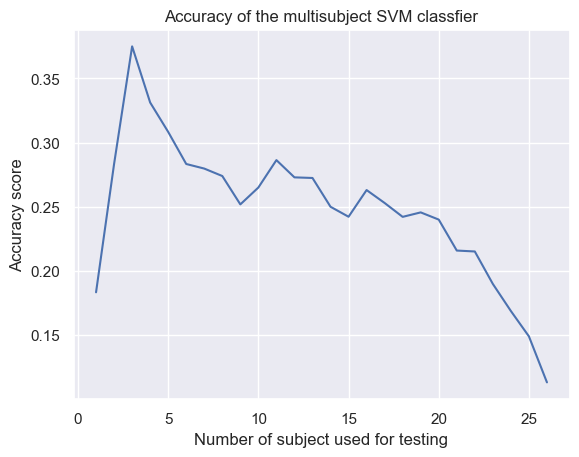

In [33]:
plt.plot(SIZE, ACCU)
plt.xlabel('Number of subject used for testing')
plt.ylabel('Accuracy score')
plt.title('Accuracy of the multisubject SVM classfier')
plt.show()

## Exploration 
What if we shuffle the data before spliting? The difference will be that the test set contains data from subject that have been use already for train. This trial should illustrate the fact that the model performace is low due to the intersubject-varrability.


In [51]:
# Split
# take still 0.27 (the size of the dataset for 1 subject but shuffle the data before splitting)
X_train, X_test, y_train, y_test  = train_test_split(combined_filtered_datasets, combined_filtered_labels, test_size=0.27, shuffle=True)
best_param = {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}  

#X_train, X_test, y_train, y_test  = train_test_split(combined_filtered_datasets_highpassed, combined_filtered_labels_highpassed, test_size=0.27, shuffle=True)
#best_param =  {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}

# Normalizing 
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  
X_test_z = scaler.transform(X_test)       

# We are using Support Vector Machine (SVM) 
clf = SVC(**best_param) 
clf.fit(X_train_z, y_train)  

# Accuracy 
accuracy_score(y_train, clf.predict(X_train_z))
accuracy_score(y_test, clf.predict(X_test_z))

0.6445714285714286

Text(0, 0.5, 'cumulative explained variance')

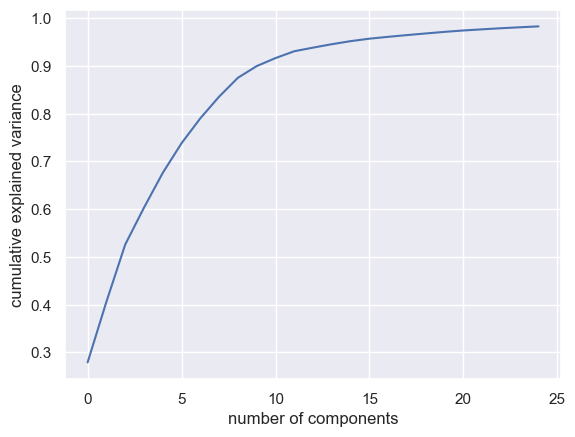

In [52]:
# Feature selection and dimension reduction with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=25)
pca.fit(X_train_z)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Accuracy score of a model with 20 PC: 0.6228571428571429


Text(0.5, 20.049999999999997, 'Predicted label')

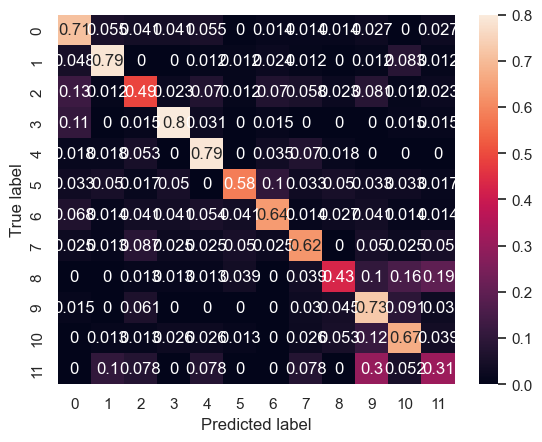

In [54]:
n_chosen_components = 20

pca = PCA(n_components=n_chosen_components)
pca.fit(X_train_z)

X_train_pca = pca.transform(X_train_z)
X_test_pca = pca.transform(X_test_z)

clf =  SVC(**best_param) 
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of a model with {n_chosen_components} PC: {accuracy}")

confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

We manage to improve the accuracy by using the shuffle dataset and the PCA, meaning that the model that use not the suffle dataset struggle to generelatize due to the intersubject variability. The only difference is that the model never see sample from the test subject.

## Additionnal : hyperparameter search very long to run and does not imporve the model 
we did not run it for all options but here above the code :

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for the SVC model
param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization parameter
    "kernel": ['linear', 'rbf', 'poly'],  # Types of kernels to try
    "gamma": ['scale', 'auto', 0.01, 0.1, 1]  # Kernel coefficient
}

# Initialize the SVC model
svc = SVC()

# Set up GridSearchCV for hyperparameter tuning
grid = GridSearchCV(svc, param_grid, cv=subject_number, scoring='accuracy')

# Fit the model using the training data
grid.fit(X_train_z, y_train)  # Use the scaled training data

# Print the best estimator and the best hyperparameters found by the grid search
print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

# Predict the labels for the test data using the best model
y_pred = grid.predict(X_test_z)

# Calculate the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of best model: {accuracy}")
